In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "train.csv"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

STORE_ID = 1
ITEM_ID = 1

HORIZON_DAYS = 365

params = {

    "S_order": 100.0,
    "H_hold": 2.0,
    "p_stockout": 10.0,
    "L": 7,
    "z_values": [1.28, 1.65, 2.05],
}

print("\n=== Parâmetros do Modelo (Hipóteses) ===")
for k, v in params.items():
    print(f"{k}: {v}")


=== Parâmetros do Modelo (Hipóteses) ===
S_order: 100.0
H_hold: 2.0
p_stockout: 10.0
L: 7
z_values: [1.28, 1.65, 2.05]


In [3]:
df = pd.read_csv(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])

sub = df[(df["store"] == STORE_ID) & (df["item"] == ITEM_ID)].sort_values("date")
if sub.empty:
    raise ValueError("Não há dados para essa combinação (store, item). Ajuste STORE_ID e ITEM_ID.")

series = sub.set_index("date")["sales"]

demand = series.iloc[-HORIZON_DAYS:] if len(series) > HORIZON_DAYS else series.copy()

mu_d = float(demand.mean())
sigma_d = float(demand.std(ddof=1))

print("\n=== Estatísticas da Demanda (recorte) ===")
print(f"Período: {demand.index.min().date()} até {demand.index.max().date()}  |  N={len(demand)} dias")
print(f"Média diária (μd): {mu_d:.4f}")
print(f"Desvio padrão diário (σd): {sigma_d:.4f}")


=== Estatísticas da Demanda (recorte) ===
Período: 2017-01-01 até 2017-12-31  |  N=365 dias
Média diária (μd): 22.1836
Desvio padrão diário (σd): 6.9533


In [4]:
D_annual = mu_d * 365.0
S_order = params["S_order"]
H_hold = params["H_hold"]

EOQ = int(max(1, round(np.sqrt((2.0 * D_annual * S_order) / H_hold)))) if H_hold > 0 else int(max(1, round(D_annual)))
print("\n=== EOQ (benchmark) ===")
print(f"Demanda anual estimada (D): {D_annual:.2f}")
print(f"EOQ (Q): {EOQ}")


=== EOQ (benchmark) ===
Demanda anual estimada (D): 8097.00
EOQ (Q): 900


In [5]:
def compute_reorder_point(mu_d: float, sigma_d: float, L: int, z: float):

    mu_LT = mu_d * L
    sigma_LT = sigma_d * np.sqrt(L)
    SS = z * sigma_LT
    R = mu_LT + SS
    return mu_LT, sigma_LT, SS, R

def simulate_qr(demand_series: pd.Series, Q: int, R: float, L: int,
                S_order: float, H_hold: float, p_stockout: float):

    holding_daily = H_hold / 365.0

    on_hand = float(R)
    pipeline = []

    total_demand = 0.0
    filled = 0.0
    stockout_units = 0.0
    stockout_days = 0
    orders = 0

    cost_order = 0.0
    cost_hold = 0.0

    stock_hist = []

    for d in demand_series.values:
        new_pipeline = []
        arriving_today = 0.0
        for days_left, qty in pipeline:
            if days_left - 1 <= 0:
                arriving_today += qty
            else:
                new_pipeline.append((days_left - 1, qty))
        pipeline = new_pipeline
        on_hand += arriving_today
        cost_hold += holding_daily * on_hand
        total_demand += float(d)
        if on_hand >= d:
            on_hand -= float(d)
            filled += float(d)
        else:
            filled += on_hand
            stockout_units += float(d) - on_hand
            on_hand = 0.0
            stockout_days += 1

        inv_position = on_hand + sum(qty for _, qty in pipeline)
        if inv_position <= R:
            pipeline.append((L, float(Q)))
            orders += 1
            cost_order += S_order

        stock_hist.append(on_hand)

    cost_stockout = p_stockout * stockout_units
    total_cost = cost_order + cost_hold + cost_stockout

    fill_rate = filled / total_demand if total_demand > 0 else 0.0
    csl = 1 - (stockout_days / len(demand_series)) if len(demand_series) > 0 else 0.0

    return {
        "Q": Q,
        "R": float(R),
        "orders": orders,
        "fill_rate": float(fill_rate),
        "CSL": float(csl),
        "stockout_units": float(stockout_units),
        "cost_order": float(cost_order),
        "cost_hold": float(cost_hold),
        "cost_stockout": float(cost_stockout),
        "total_cost": float(total_cost),
        "stock_hist": np.array(stock_hist),
    }


In [6]:
results = []
L = params["L"]

for z in params["z_values"]:
    mu_LT, sigma_LT, SS, R = compute_reorder_point(mu_d, sigma_d, L, z)
    out = simulate_qr(
        demand_series=demand,
        Q=EOQ,
        R=R,
        L=L,
        S_order=params["S_order"],
        H_hold=params["H_hold"],
        p_stockout=params["p_stockout"],
    )
    out.update({
        "policy": "Q,R",
        "z": float(z),
        "SS": float(SS),
        "mu_LT": float(mu_LT),
        "sigma_LT": float(sigma_LT),
        "store": STORE_ID,
        "item": ITEM_ID,
        "horizon_days": len(demand),
    })
    results.append(out)

res_df = pd.DataFrame(results)
res_df = res_df.sort_values("z").reset_index(drop=True)

print("\n=== Resultados (resumo) ===")
print(res_df[["z", "Q", "R", "SS", "fill_rate", "CSL", "stockout_units", "total_cost"]])

# Salvar tabela
res_csv_path = os.path.join(OUTPUT_DIR, "results_qr.csv")
res_df.to_csv(res_csv_path, index=False)
print(f"\nTabela salva em: {res_csv_path}")


=== Resultados (resumo) ===
      z    Q           R         SS  fill_rate       CSL  stockout_units  \
0  1.28  900  178.832638  23.547706   0.996645  0.994521       27.167362   
1  1.65  900  185.639397  30.354465   0.997609  0.997260       19.360603   
2  2.05  900  192.998055  37.713123   0.998518  0.997260       12.001945   

    total_cost  
0  2161.267457  
1  2098.938042  
2  2037.540822  

Tabela salva em: outputs/results_qr.csv


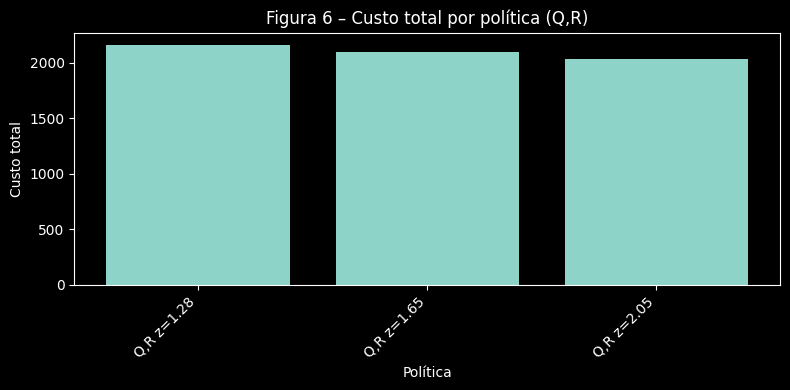

In [10]:
labels = [f"Q,R z={z:.2f}" for z in res_df["z"]]
costs = res_df["total_cost"].values
fill_rates = res_df["fill_rate"].values

plt.figure(figsize=(8,4))
plt.bar(labels, costs)
plt.title("Figura 6 – Custo total por política (Q,R)")
plt.xlabel("Política")
plt.ylabel("Custo total")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
fig1_path = os.path.join(OUTPUT_DIR, "Figura_1_Custo_Total.png")
plt.savefig(fig1_path, dpi=300)
plt.show()

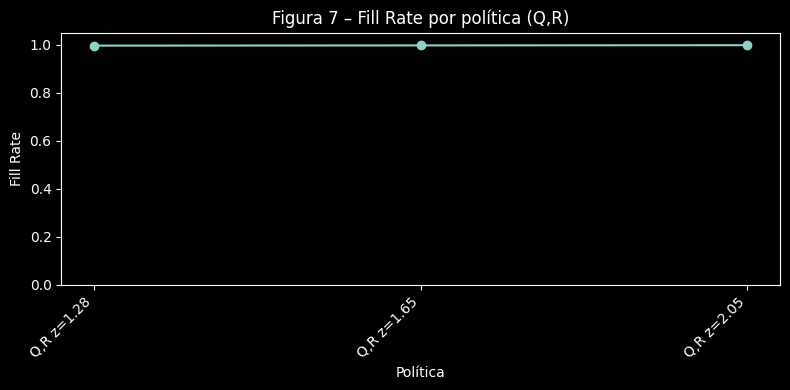

In [11]:
plt.figure(figsize=(8,4))
plt.plot(labels, fill_rates, marker="o")
plt.title("Figura 7 – Fill Rate por política (Q,R)")
plt.xlabel("Política")
plt.ylabel("Fill Rate")
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
fig2_path = os.path.join(OUTPUT_DIR, "Figura_2_Fill_Rate.png")
plt.savefig(fig2_path, dpi=300)
plt.show()

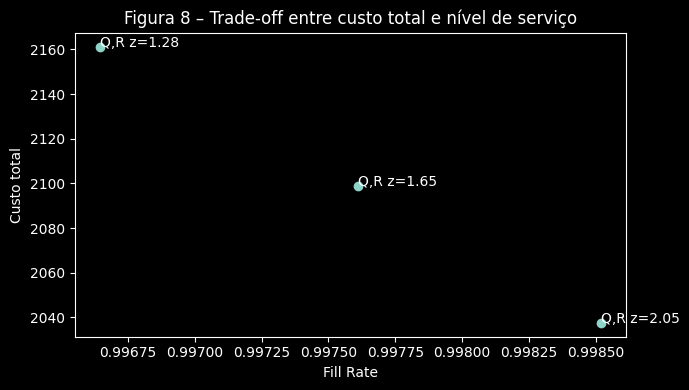

In [12]:
plt.figure(figsize=(7,4))
plt.scatter(fill_rates, costs)
for i, label in enumerate(labels):
    plt.annotate(label, (fill_rates[i], costs[i]))
plt.title("Figura 8 – Trade-off entre custo total e nível de serviço")
plt.xlabel("Fill Rate")
plt.ylabel("Custo total")
plt.tight_layout()
fig3_path = os.path.join(OUTPUT_DIR, "Figura_3_Tradeoff.png")
plt.savefig(fig3_path, dpi=300)
plt.show()

In [ ]:


print("\n=== Figuras salvas ===")
print(fig1_path)
print(fig2_path)
print(fig3_path)

print("\n Execução finalizada com sucesso.")